**Name :**  Nayeem Ahmed Abdul Sattar

**Neptune Code:** MCVGRB

Please, Run this file first then run the "whats_cooking_tf-idf_vec.ipynb". Due to memory space i can't able to run all the code in the same file. please find the attachment of the dataset files in zip file.

My project is all about implementing 8 classification model using scikit learn apply these 8 model on count vectorized data and tf-idf vectorized data respectively and comparing the result and come up with best model in each vectorizer methods.

In [1]:
from google.colab import files
files.upload()

Saving test.json to test (1).json


{'test.json': b'[\n  {\n    "id": 18009,\n    "ingredients": [\n      "baking powder",\n      "eggs",\n      "all-purpose flour",\n      "raisins",\n      "milk",\n      "white sugar"\n    ]\n  },\n  {\n    "id": 28583,\n    "ingredients": [\n      "sugar",\n      "egg yolks",\n      "corn starch",\n      "cream of tartar",\n      "bananas",\n      "vanilla wafers",\n      "milk",\n      "vanilla extract",\n      "toasted pecans",\n      "egg whites",\n      "light rum"\n    ]\n  },\n  {\n    "id": 41580,\n    "ingredients": [\n      "sausage links",\n      "fennel bulb",\n      "fronds",\n      "olive oil",\n      "cuban peppers",\n      "onions"\n    ]\n  },\n  {\n    "id": 29752,\n    "ingredients": [\n      "meat cuts",\n      "file powder",\n      "smoked sausage",\n      "okra",\n      "shrimp",\n      "andouille sausage",\n      "water",\n      "paprika",\n      "hot sauce",\n      "garlic cloves",\n      "browning",\n      "lump crab meat",\n      "vegetable oil",\n      "all-p

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd

import re
import string
import time
import json

import re
from nltk.stem import WordNetLemmatizer


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

import plotly.plotly as py
import plotly.tools as tls
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from collections import Counter
import nltk
nltk.download('wordnet')
%matplotlib inline


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df_train = pd.read_json('train.json', encoding='utf-8')
df_test = pd.read_json('test.json', encoding='utf-8')
df_train.shape, df_test.shape

((39774, 3), (9944, 2))

In [9]:
df_train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [0]:
counters = {}
for cuisine in df_train['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (df_train['cuisine'] == cuisine)
    for ingredients in df_train[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [12]:
counters['italian'].most_common(10)

[('salt', 3454),
 ('olive oil', 3111),
 ('garlic cloves', 1619),
 ('grated parmesan cheese', 1580),
 ('garlic', 1471),
 ('ground black pepper', 1444),
 ('extra-virgin olive oil', 1362),
 ('onions', 1240),
 ('water', 1052),
 ('butter', 1030)]

In [13]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
greek,salt,olive oil,dried oregano,garlic cloves,feta cheese crumbles,extra-virgin olive oil,fresh lemon juice,ground black pepper,garlic,pepper
southern_us,salt,butter,all-purpose flour,sugar,large eggs,baking powder,water,unsalted butter,milk,buttermilk
filipino,salt,garlic,water,onions,soy sauce,pepper,oil,sugar,carrots,ground black pepper
indian,salt,onions,garam masala,water,ground turmeric,garlic,cumin seed,ground cumin,vegetable oil,oil
jamaican,salt,onions,water,garlic,ground allspice,pepper,scallions,dried thyme,black pepper,garlic cloves
spanish,salt,olive oil,garlic cloves,extra-virgin olive oil,onions,water,tomatoes,ground black pepper,red bell pepper,pepper
italian,salt,olive oil,garlic cloves,grated parmesan cheese,garlic,ground black pepper,extra-virgin olive oil,onions,water,butter
mexican,salt,onions,ground cumin,garlic,olive oil,chili powder,jalapeno chilies,sour cream,avocado,corn tortillas
chinese,soy sauce,sesame oil,salt,corn starch,sugar,garlic,water,green onions,vegetable oil,scallions
british,salt,all-purpose flour,butter,milk,eggs,unsalted butter,sugar,onions,baking powder,large eggs


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [15]:
df_train.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

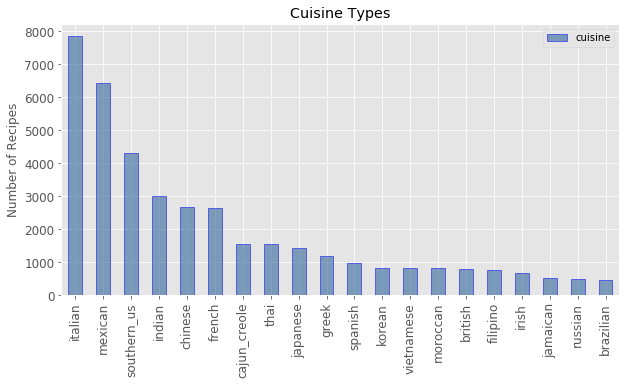

In [16]:
plt.style.use('ggplot')
df_train.cuisine.value_counts().plot(kind = 'bar',
                              title='Cuisine Types',
                              figsize=(10,5),
                              legend=True,
                              fontsize=12,
                              align='center',
                              color=(0.2, 0.4, 0.6, 0.6),
                              edgecolor='blue')
plt.ylabel("Number of Recipes", fontsize=12)
plt.show()

In [0]:
def pre_processing_(recipe):
    
    wnl = WordNetLemmatizer()
    
    # converting to lower-case
    recipe = [str.lower(ingredient) for ingredient in recipe]
    
    # removing brand-names
    def delete_brand_(ingredient):
        
        
        ingredient = re.sub("country crock|i can't believe it's not butter!|bertolli|oreo|hellmann's"
                            , '', ingredient)
        ingredient = re.sub("red gold|hidden valley|original ranch|frank's|redhot|lipton", '', ingredient)
        ingredient = re.sub("recipe secrets|eggland's best|hidden valley|best foods|knorr|land o lakes"
                            , '', ingredient)
        ingredient = re.sub("sargento|johnsonville|breyers|diamond crystal|taco bell|bacardi", '', ingredient)
        ingredient = re.sub("mccormick|crystal farms|yoplait|mazola|new york style panetini", '', ingredient)
        ingredient = re.sub("ragu|soy vay|tabasco|truvía|crescent recipe creations|spice islands", '', ingredient)
        ingredient = re.sub("wish-bone|honeysuckle white|pasta sides|fiesta sides", '', ingredient)
        ingredient = re.sub("veri veri teriyaki|artisan blends|home originals|greek yogurt|original ranch"
                            , '', ingredient)
        ingredient = re.sub("jonshonville", '', ingredient)

       
        ingredient = re.sub("old el paso|pillsbury|progresso|betty crocker|green giant|hellmannâ€", '', ingredient)

        
        ingredient = re.sub("oscar mayer deli fresh smoked", '', ingredient)
        
        return ingredient
    
    
    def delete_state_(ingredient):
    
        ingredient = re.sub('frozen|chopped|ground|fresh|powdered', '', ingredient)
        ingredient = re.sub('sharp|crushed|grilled|roasted|sliced', '', ingredient)
        ingredient = re.sub('cooked|shredded|cracked|minced|finely', '', ingredient)        
     
        return ingredient
    
    
    def delete_comma_(ingredient):
        
        ingredient = ingredient.split(',')
        ingredient = ingredient[0]
        
        return ingredient

    
    def original_(ingredient):
        
        
        ingredient = re.sub('[0-9]', '', ingredient)
        
        
        ingredient = ingredient.replace("oz.", '')
        ingredient = re.sub('[&%()®™/]', '', ingredient)
        ingredient = re.sub('[-.]', '', ingredient)
        
        # lemmatize
        ingredient = wnl.lemmatize(ingredient)
        
        return ingredient

    
    def delete_space_(ingredient):
        
        ingredient = ingredient.strip()
        
        return ingredient

    recipe = [delete_brand_(ingredient) for ingredient in recipe]
    recipe = [delete_state_(ingredient) for ingredient in recipe]
    recipe = [delete_comma_(ingredient) for ingredient in recipe]
    recipe = [original_(ingredient) for ingredient in recipe]
    recipe = [delete_space_(ingredient) for ingredient in recipe]

    return recipe

In [0]:
df_train['ingredients'] = df_train['ingredients'].apply(lambda x : pre_processing_(x))
df_test['ingredients'] = df_test['ingredients'].apply(lambda x : pre_processing_(x))


In [0]:
df_train['all_ingredients'] = df_train['ingredients'].map(";".join)
df_test['all_ingredients'] = df_train['ingredients'].map(";".join)

In [20]:
df_train.head()


,cuisine,id,ingredients,all_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce;black olives;grape tomatoes;ga...
1,southern_us,25693,"[plain flour, pepper, salt, tomato, black pepp...",plain flour;pepper;salt;tomato;black pepper;th...
2,filipino,20130,"[egg, pepper, salt, mayonaise, cooking oil, gr...",egg;pepper;salt;mayonaise;cooking oil;green ch...
3,indian,22213,"[water, vegetable oil, wheat, salt]",water;vegetable oil;wheat;salt
4,indian,13162,"[black pepper, shallot, cornflour, cayenne pep...",black pepper;shallot;cornflour;cayenne pepper;...


In [0]:
cv = CountVectorizer()

In [0]:
X = cv.fit_transform(df_train['all_ingredients'].values)
X_test = cv.fit_transform(df_test['all_ingredients'].values)

In [12]:
X.shape


<9944x2202 sparse matrix of type '<class 'numpy.int64'>'
	with 175282 stored elements in Compressed Sparse Row format>

In [13]:
print(list(cv.vocabulary_.keys())[:100])

['romaine', 'lettuce', 'black', 'olives', 'grape', 'tomatoes', 'garlic', 'pepper', 'purple', 'onion', 'seasoning', 'garbanzo', 'beans', 'feta', 'cheese', 'crumbles', 'plain', 'flour', 'salt', 'tomato', 'thyme', 'egg', 'green', 'yellow', 'corn', 'meal', 'milk', 'vegetable', 'oil', 'mayonaise', 'cooking', 'chilies', 'chicken', 'breasts', 'powder', 'soy', 'sauce', 'butter', 'livers', 'water', 'wheat', 'shallot', 'cornflour', 'cayenne', 'paste', 'lemon', 'juice', 'chili', 'passata', 'cumin', 'boneless', 'skinless', 'thigh', 'garam', 'masala', 'double', 'cream', 'natural', 'yogurt', 'bay', 'leaf', 'sugar', 'ginger', 'root', 'cinnamon', 'vanilla', 'extract', 'baking', 'olive', 'medium', 'shrimp', 'cilantro', 'jalapeno', 'flat', 'parsley', 'skirt', 'steak', 'white', 'vinegar', 'sea', 'chorizo', 'sausage', 'pistachio', 'nuts', 'almond', 'bark', 'dried', 'cranberries', 'pineapple', 'pork', 'poblano', 'peppers', 'tortillas', 'cheddar', 'iceberg', 'lime', 'basil', 'extravirgin', 'kosher', 'piment

In [0]:
enc = LabelEncoder()
y = enc.fit_transform(df_train.cuisine)

In [51]:
y[:100]


array([ 6, 16,  4,  7,  7, 10, 17,  9, 13,  9,  9,  3,  9, 13,  9,  7,  1,
        9, 18, 19, 18, 13, 16,  3,  9,  3,  2,  9,  3, 13,  9,  2, 13, 18,
        9,  2,  9,  4, 16, 16,  9,  0, 13,  7, 13,  3,  5, 16, 16, 16, 11,
       16,  9, 16,  9, 10, 11,  7,  9,  8, 18, 18,  7, 10,  9, 18, 12,  5,
        5, 16, 17,  7, 14,  9,  9, 14, 14, 19, 11, 13,  2, 16,  5,  7,  7,
        9,  9,  7, 12, 17,  9, 16, 16,  6, 13, 13, 16,  7,  9,  9])

In [56]:
enc.classes_

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

In [0]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)

In [18]:
yv=[]
start_time = time.time()
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
score = logistic.score(X_validation, y_validation)
score = round(score*100,1)
yv.append(score)
print("Logistic Regression - Validation accuracy : ", score)
print("\nTime taken : {0:.3f} min.".format((time.time() - start_time) / float(60)))


Logistic Regression - Validation accuracy :  78.7

Time taken : 0.176 min.


In [30]:
start_time = time.time()
rf_classifier = RandomForestClassifier(criterion='entropy', max_features=3,n_estimators=1000,n_jobs=2,oob_score=True,random_state=0)
rf_classifier.fit(X_train, y_train)
score = rf_classifier.score(X_validation, y_validation)
score = round(score*100,1)
yv.append(score)
print("Random Forest Classifier - Validation accuracy : ", score)
print("\nTime taken : {0:.3f} min.".format((time.time() - start_time) / float(60)))


Random Forest Classifier - Validation accuracy :  75.4

Time taken : 5.808 min.


In [31]:
start_time = time.time()
svm_classifier = LinearSVC(multi_class='ovr')
svm_classifier.fit(X_train, y_train)
score =svm_classifier.score(X_validation, y_validation)
score = round(score*100,1)
yv.append(score)
print("SVM Classifier - Validation accuracy : ", score)
print("\nTime taken : {0:.3f} min.".format((time.time() - start_time) / float(60)))


SVM Classifier - Validation accuracy :  77.7

Time taken : 0.211 min.


In [32]:
start_time = time.time()
ann_classifier = MLPClassifier(hidden_layer_sizes=(400,500,400))
ann_classifier.fit(X_train, y_train)
score = ann_classifier.score(X_validation, y_validation)
score = round(score*100,1)
yv.append(score)
print("Neural Network Classifier - Validation accuracy : ", score)
print("\nTime taken : {0:.3f} min.".format((time.time() - start_time) / float(60)))


Neural Network Classifier - Validation accuracy :  78.1

Time taken : 7.187 min.


In [33]:
start_time = time.time()
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)
score = xgb_classifier.score(X_validation, y_validation)
score = round(score*100,1)
print("XGB Classifier - Validation accuracy : ", score)
print("\nTime taken : {0:.3f} min.".format((time.time() - start_time) / float(60)))
yv.append(score)

XGB Classifier - Validation accuracy :  73.4

Time taken : 0.875 min.


In [34]:
start_time = time.time()
skl_clf = GradientBoostingClassifier()
skl_clf.fit(X_train, y_train)
score= skl_clf.score(X_validation, y_validation)
score = round(score*100,1)
print("Gradient Boosting Classifier - Validation accuracy : ", score)
print("\nTime taken : {0:.3f} min.".format((time.time() - start_time) / float(60)))
yv.append(score)

Gradient Boosting Classifier - Validation accuracy :  75.2

Time taken : 3.484 min.


In [35]:
start_time = time.time()
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train,y_train)
score = naive_bayes.score(X_validation, y_validation)
score = round(score*100,1)
print("Naive Bayes Classifier - Validation accuracy : ", score)
print("\nTime taken : {0:.3f} min.".format((time.time() - start_time) / float(60)))
yv.append(score)

Naive Bayes Classifier - Validation accuracy :  72.8

Time taken : 0.001 min.


In [36]:
start_time = time.time()
SGD_clf = linear_model.SGDClassifier()
SGD_clf.fit(X_train,y_train)
score = SGD_clf.score(X_validation, y_validation)
score = round(score*100,1)
print("SGD Classifier - Validation accuracy : ", score)
print("\nTime taken : {0:.3f} min.".format((time.time() - start_time) / float(60)))
yv.append(score)

SGD Classifier - Validation accuracy :  77.7

Time taken : 0.017 min.


In [37]:

objects = ['Logistic Regression','Random Forest','SVM Classifier','Neural network - MLP Classifier','XGB classifier','Gradient Boosting Classifier','Naive bayes classifier','SGD classifier']

print("Models and it's validation accuracy's using count vectorizer \n" )
for i in objects:
  j=objects.index(i)
  print(i,' : ',yv[j])



Models and it's validation accuracy's using count vectorizer 

Logistic Regression  :  78.6
Random Forest  :  75.4
SVM Classifier  :  77.7
Neural network - MLP Classifier  :  78.1
XGB classifier  :  73.4
Gradient Boosting Classifier  :  75.2
Naive bayes classifier  :  72.8
SGD classifier  :  77.7


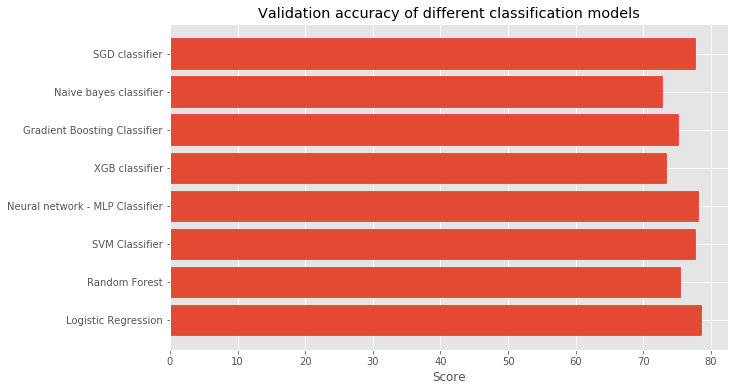

In [40]:
fig, ax = plt.subplots(figsize=(10,6))
score = yv
objects = ['Logistic Regression','Random Forest','SVM Classifier','Neural network - MLP Classifier','XGB classifier','Gradient Boosting Classifier','Naive bayes classifier','SGD classifier']

plt.barh(objects,score, align='center',edgecolor='red')
ax.set_xlabel('Score')
ax.set_title('Validation accuracy of different classification models')

plt.show()




Text(0.5, 64.59999999999997, 'Predicted label')

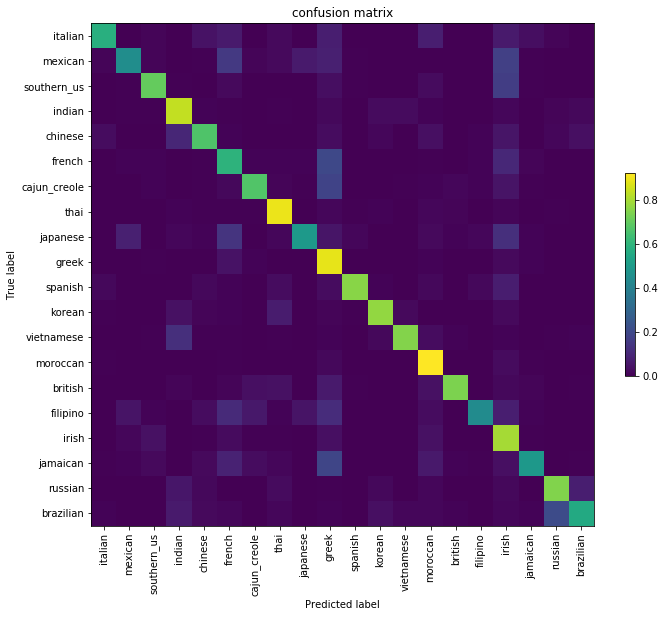

In [43]:
#Conclusion: Logistic Regression is Best Model
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 10))

cm = confusion_matrix(y_validation, logistic.predict(X_validation))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = df_train['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [44]:
y_pred = logistic.predict(X_validation)
print(classification_report(y_validation, y_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.71      0.58      0.64        89
     mexican       0.65      0.45      0.53       183
 southern_us       0.77      0.71      0.74       311
      indian       0.83      0.84      0.84       525
     chinese       0.63      0.67      0.65       133
      french       0.61      0.60      0.61       561
cajun_creole       0.76      0.67      0.72       233
        thai       0.88      0.90      0.89       616
    japanese       0.67      0.50      0.57       136
       greek       0.80      0.89      0.84      1525
     spanish       0.84      0.76      0.80        96
      korean       0.84      0.77      0.80       287
  vietnamese       0.84      0.75      0.79       187
    moroccan       0.90      0.92      0.91      1304
     british       0.85      0.74      0.79       163
    filipino       0.68      0.45      0.54       101
       irish       0.69      0.80      0.74       851
    jamaican       0.69    

In [0]:
#Performing Pediction using Logistic Regression model

X_all = df_train.append(df_test)
ingredient_list = X_all['all_ingredients']
cv = CountVectorizer().fit(ingredient_list)
ingredient_list_count = cv.transform(ingredient_list)


In [0]:

tfidf_transformer = TfidfTransformer().fit(ingredient_list_count)
ingredient_list_tfidf = tfidf_transformer.transform(ingredient_list_count)
X_test = ingredient_list_tfidf[39774:]

In [0]:

#Making Prediction using best accuracy defined model 
X_test_index = df_test['id']

predictions = logistic.predict(X_test)


In [0]:
#Changing encoded value to Cuisine type

pred = {0: 'brazilian',1: 'british',2: 'cajun_creole',3: 'chinese',4: 'filipino',
       5:'french', 6:'greek', 7:'indian',8: 'irish', 9:'italian',10: 'jamaican',
       11:'japanese', 12:'korean',13: 'mexican', 14:'moroccan', 15:'russian',
       16:'southern_us', 17:'spanish',18: 'thai', 19:'vietnamese'} 

predictions = [pred[item] for item in predictions]

In [60]:
res = pd.DataFrame({
    "id":X_test_index,
    "cuisine":predictions
})

res.head()



,id,cuisine
0,18009,greek
1,28583,southern_us
2,41580,italian
3,29752,italian
4,35687,indian


In [0]:
res.to_csv("sol.csv",header=True,index=False)